In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Using Skicit-learn to split data into training and testing sets 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix

import rasterio
import geopandas as gpd

import pystac_client 
import planetary_computer as pc

from shapely.geometry import Polygon

In [8]:
def iceplant_counts(df):
    return df.filter(items=['iceplant']).groupby(['iceplant']).size().reset_index(name='count')

In [3]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_non_iceplant_vegetation.csv')
noniceplant_features_df = pd.read_csv(fp)
noniceplant_features_df.head(4)

Unnamed: 0                                       geometry              x  \
0           0  POINT (237140.55244983404 3814526.1699873866)  237140.552450   
1           1  POINT (236884.12087633682 3814547.9049896635)  236884.120876   
2           2  POINT (237192.64798213766 3814447.7745699394)  237192.647982   
3           3   POINT (237097.1258511347 3814436.9883266105)  237097.125851   

              y    r    g    b  nifr  iceplant  
0  3.814526e+06  163  144  116   183         0  
1  3.814548e+06  114  103   95   140         0  
2  3.814448e+06   59   67   69   137         0  
3  3.814437e+06  132  117  107   138         0

In [4]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_BIG.csv')
features_df = pd.read_csv(fp)
features_df.head(4)

Unnamed: 0                                       geometry              x  \
0           0  POINT (238502.90962098842 3810767.0101709925)  238502.909621   
1           1   POINT (238531.08502453016 3810765.502552128)  238531.085025   
2           2  POINT (238514.12151877338 3810770.2447426612)  238514.121519   
3           3    POINT (238494.7719131412 3810776.858465532)  238494.771913   

              y   r   g   b  nifr  iceplant  
0  3.810767e+06  87  80  87   140         1  
1  3.810766e+06  85  81  84   149         1  
2  3.810770e+06  96  83  89   149         1  
3  3.810777e+06  93  89  86   161         1

In [5]:
features_df = pd.concat([features_df,
                         noniceplant_features_df.sample(frac=0.01)])

In [6]:
features_df.drop(['geometry','Unnamed: 0','x','y'],axis=1,inplace=True)

In [9]:
iceplant_counts(features_df)

iceplant  count
0         0   5113
1         1   1609

In [10]:
features_df['ndvi']=(features_df.nifr - features_df.r)/(features_df.nifr + features_df.r)
#copy.drop_duplicates(subset = ['r','g','b','nifr'])
#features_df

In [21]:
features_df.drop(features_df[features_df['ndvi'] < 0.2].index)
vegetation = features_df[features_df.ndvi>0.2]
vegetation.drop('ndvi',axis=1,inplace=True)
vegetation

/tmp/ipykernel_932/1257277935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop('ndvi',axis=1,inplace=True)


r   g   b  nifr  iceplant
0       87  80  87   140         1
1       85  81  84   149         1
2       96  83  89   149         1
3       93  89  86   161         1
4       84  78  85   135         1
...     ..  ..  ..   ...       ...
71450   25  36  55    52         0
89628   39  52  63   105         0
31384   60  62  68   164         0
135791  26  36  55    50         0
75562   91  96  91   173         0

[4614 rows x 5 columns]

In [22]:
iceplant_counts(vegetation)

iceplant  count
0         0   3100
1         1   1514

## Crete test and training sets

In [57]:
from sklearn.metrics import RocCurveDisplay

def test_train_from_df(df,test_size=0.3):
    # Labels are the values we want to predict
    labels = np.array(df['iceplant'])
    #Convert to numpy array
    features = np.array(df.drop('iceplant', axis = 1))
    return train_test_split(features, labels, test_size = test_size, random_state = 42)

# --- check proportions of ice plant vs no ice plant in train/test sets
def test_train_proportions(train_labels, test_labels):
    print('TRAIN SET: Iceplant / no iceplant counts')
    unique, counts = np.unique(train_labels,return_counts=True)
    print(np.column_stack((unique,counts)), '\n')

    print('TEST SET: Iceplant / no iceplant counts')
    unique, counts = np.unique(test_labels,return_counts=True)
    print(np.column_stack((unique,counts)))
    print()
    return

# --- check shapes of train/test features/labels
def  train_test_shapes(train_features, train_labels, test_features, test_labels):
    print('Training Features Shape:', train_features.shape) 
    print('Training Labels Shape:', train_labels.shape) 
    print('Testing Features Shape:', test_features.shape) 
    print('Testing Labels Shape:', test_labels.shape)
    print()
    return


def print_accuracy_info(test_labels,predictions_class):
    N = test_labels.shape[0]
    results = confusion_matrix(test_labels,predictions_class, normalize = 'true')
    
    confmtx = confusion_matrix(test_labels,predictions_class)
    print('true negatives:', confmtx[0,0], 
          '    false positives:', confmtx[0,1])
    print('false negatives:', confmtx[1,0], 
          '    true positives:', confmtx[1,1])
    print()
    unique, counts = np.unique(test_labels,return_counts=True)

    print('true negative %:', np.round(confmtx[0,0]/counts[0]*100,2))
    print('true positive rate %:', np.round(confmtx[1,1]/counts[1]*100,2))
    print()
    print('accuracy %:', np.round( (confmtx[1,1] + confmtx[0,0])/test_labels.shape[0]*100,2))
    return

def plot_roc(rfc, test_features, test_labels):
    ax = plt.gca()
    rf_disp = RocCurveDisplay.from_estimator(rfc, test_features, test_labels, ax=ax)
    return

def print_abs_errors(predictions_class, test_labels):# Calculate the absolute errors
    errors_class = abs(predictions_class - test_labels)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors_class), 2))
    return

def print_rfc_evaluation(rfc, test_features, test_labels, prediction):
    print_abs_errors(predictions_class, test_labels)
    print()
    print_accuracy_info(test_labels,predictions)
    plot_roc(rfc, test_features, test_labels)
    print()
    return

In [58]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = test_train_from_df(vegetation)

train_test_shapes(train_features, train_labels, test_features, test_labels)
test_train_proportions(train_labels, test_labels)

Training Features Shape: (3229, 4)
Training Labels Shape: (3229,)
Testing Features Shape: (1385, 4)
Testing Labels Shape: (1385,)

TRAIN SET: Iceplant / no iceplant counts
[[   0 2188]
 [   1 1041]] 

TEST SET: Iceplant / no iceplant counts
[[  0 912]
 [  1 473]]



In [41]:
rfc = RandomForestClassifier(n_estimators = 100, 
                           random_state = 42)
rfc.fit(train_features,train_labels)

RandomForestClassifier(random_state=42)

In [50]:
predictions = rfc.predict(test_features)

Mean Absolute Error: 0.02

true negatives: 894     false positives: 18
false negatives: 16     true positives: 457

true negative %: 98.03
true positive rate %: 96.62

accuracy %: 97.55


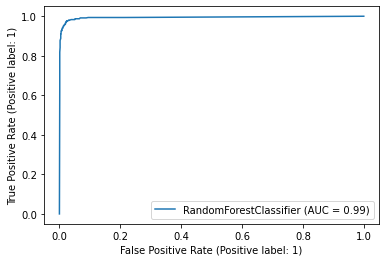

In [55]:
print_rfc_evaluation(rfc, test_features, test_labels, predictions)

## Applying RFC model to NAIP subsets

In [59]:
def open_window_in_scene(itemid, reduce_box):
    # accesing Azure storage using pystac client
    URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(URL)

    # ********* HERE I KNOW WHICH IMAGE TEHSE POINTS ARE IN ******
    itemid = itemid,
    search = catalog.search(
        collections=["naip"],
        ids = itemid
    )
    item = list(search.get_items())[0]
    # sign and open item
    href = pc.sign(item.assets["image"].href)
    ds = rasterio.open(href)


    reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
    reduce = reduce.to_crs(ds.crs)

    win = ds.window(*reduce.total_bounds)
    subset = rasterio.open(href).read([1,2,3,4], window=win)
    return subset


def predict_over_subset(itemid, reduce_box,rfc):
    subset = open_window_in_scene(itemid, reduce_box)
    # reshape image into a np.array where each row is a pixel and the columns are the bands
    pixels = subset.reshape([4,-1]).T
    predictions_class = rfc.predict(pixels)
    # turn back into original raster dimensions
    return predictions_class.reshape([subset.shape[1],-1])


In [60]:
itemid='ca_m_3411934_sw_11_060_20180722_20190209'

# use one of these polygons to make a window and load only the portion of the raster we need

#  Campus Point + Campus + Goleta Beach
# reduce_box = Polygon([
#     [-119.8533036004,34.4025961754],
#     [-119.8322357862,34.4025961754],
#     [-119.8322357862,34.4198342586],
#     [-119.8533036004,34.4198342586],
#     [-119.8533036004,34.4025961754]])


# Only Campus Point
reduce_box = Polygon([
    [-119.8534713523,34.4028697719],
    [-119.8409772016,34.4028697719],
    [-119.8409772016,34.4129840686],
    [-119.8534713523,34.4129840686],
    [-119.8534713523,34.4028697719]])

campus_point_iceplant = predict_over_subset(itemid, reduce_box, rfc)

ERROR 1: Request for 268295692-271616423 failed


### Preparing data to input into RFC predict

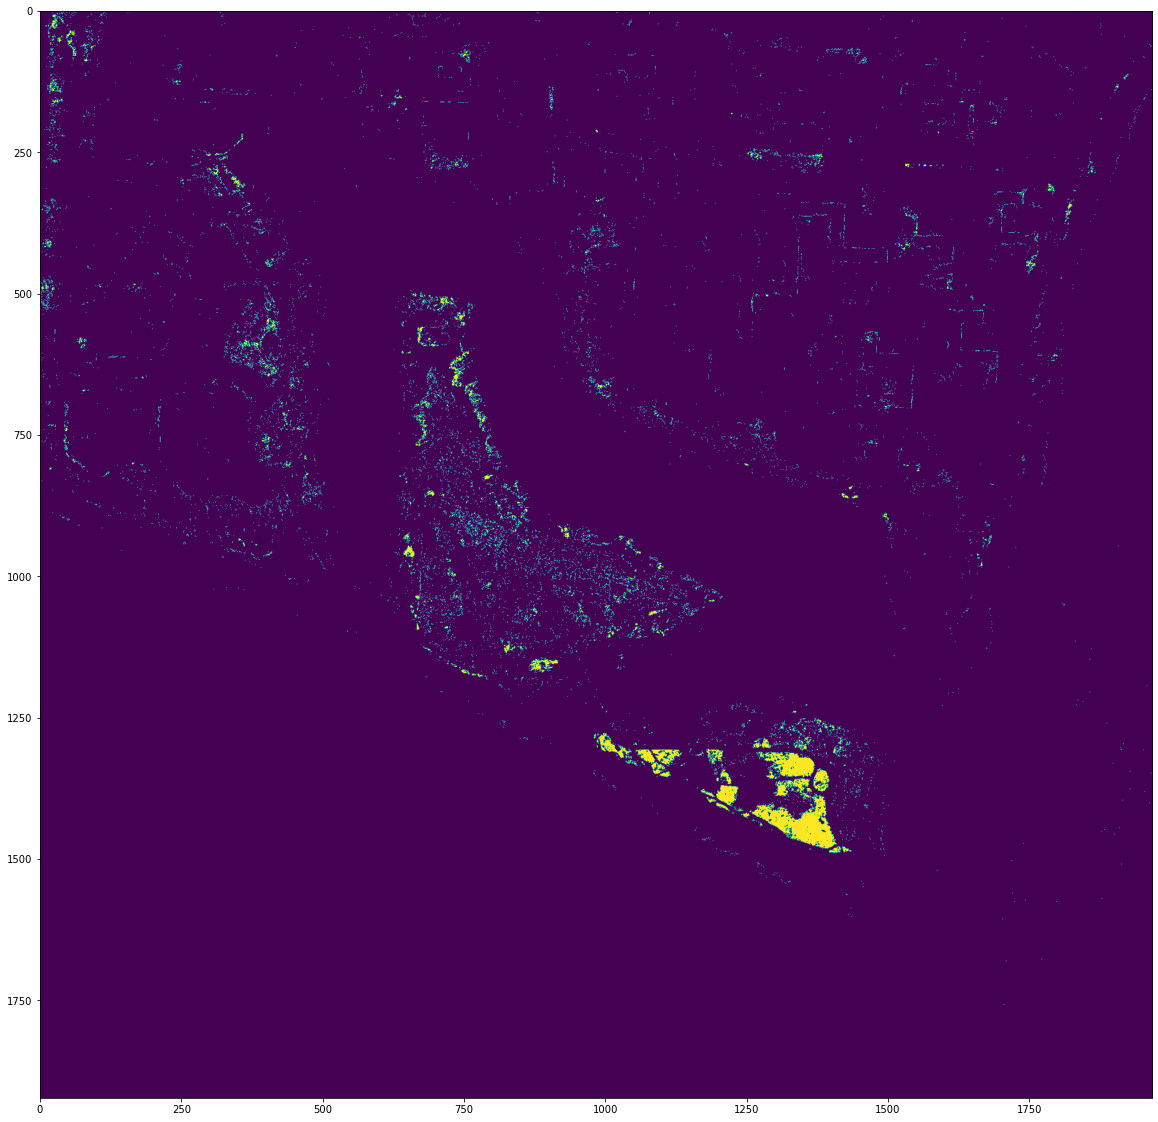

In [61]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(pred_to_pixels)
plt.show()

In [62]:

# ********* DANGERMOND RESERVE 2018 NAIP SCENE ******
itemid = 'ca_m_3412037_nw_10_060_20180913_20190208'

reduce_box = Polygon([
    [-120.4731712312,34.4464554252],
    [-120.4602250497,34.4464554252],
    [-120.4602250497,34.4566394481],
    [-120.4731712312,34.4566394481],
    [-120.4731712312,34.4464554252]])

In [65]:
dangermond_iceplant = predict_over_subset(itemid, reduce_box,rfc)

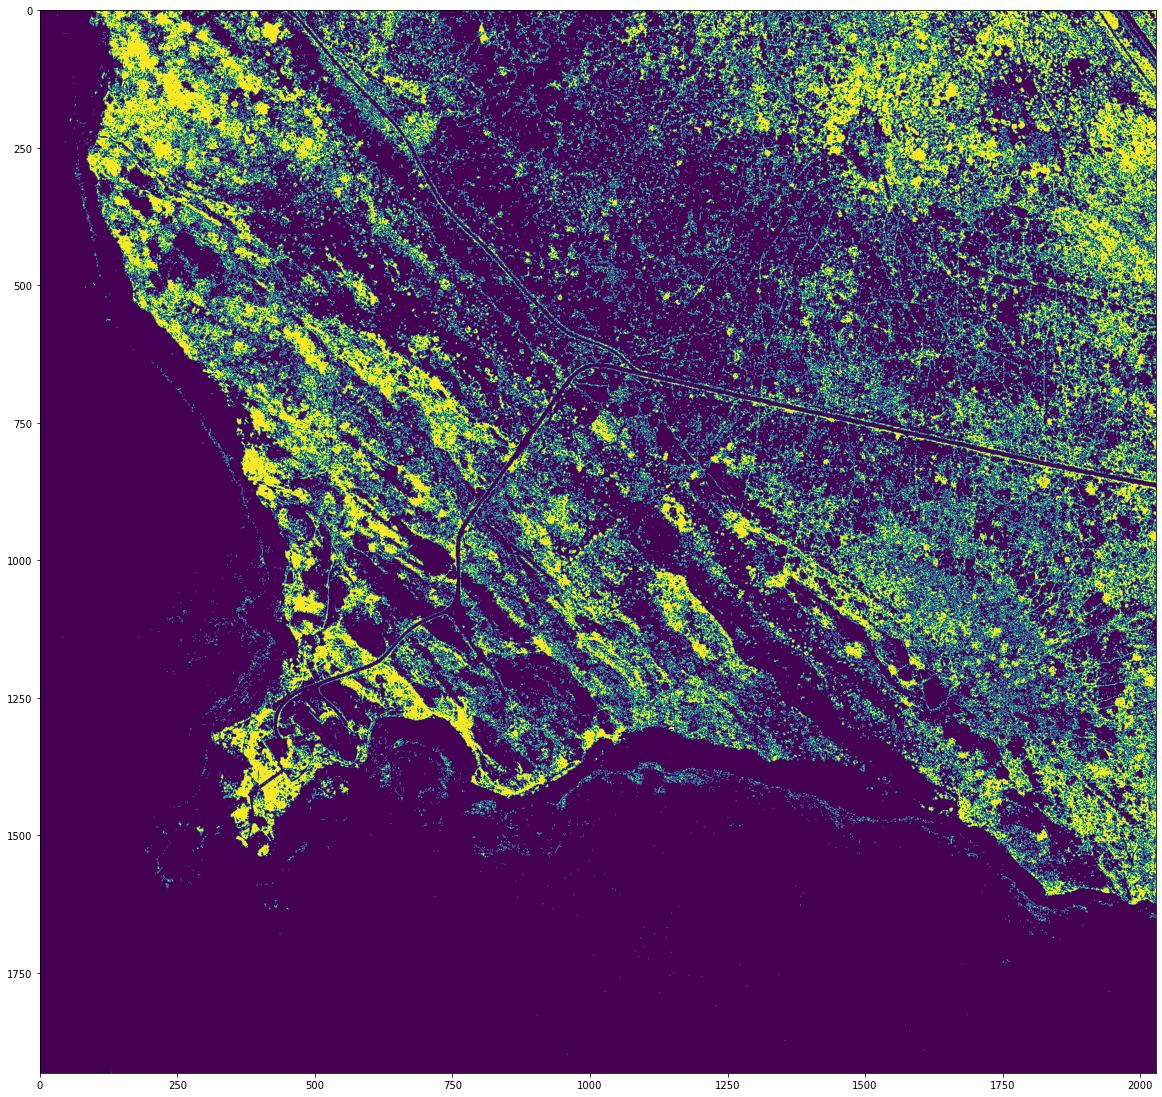

In [66]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(dangermond_iceplant)
plt.show()

In [67]:
reduce_box2 = Polygon([
    [-120.4694755983,34.4526766824],
    [-120.4593511485,34.4526766824],
    [-120.4593511485,34.4611333067],
    [-120.4694755983,34.4611333067],
    [-120.4694755983,34.4526766824]])

dangermond_iceplant2 = predict_over_subset(itemid, reduce_box2,rfc)

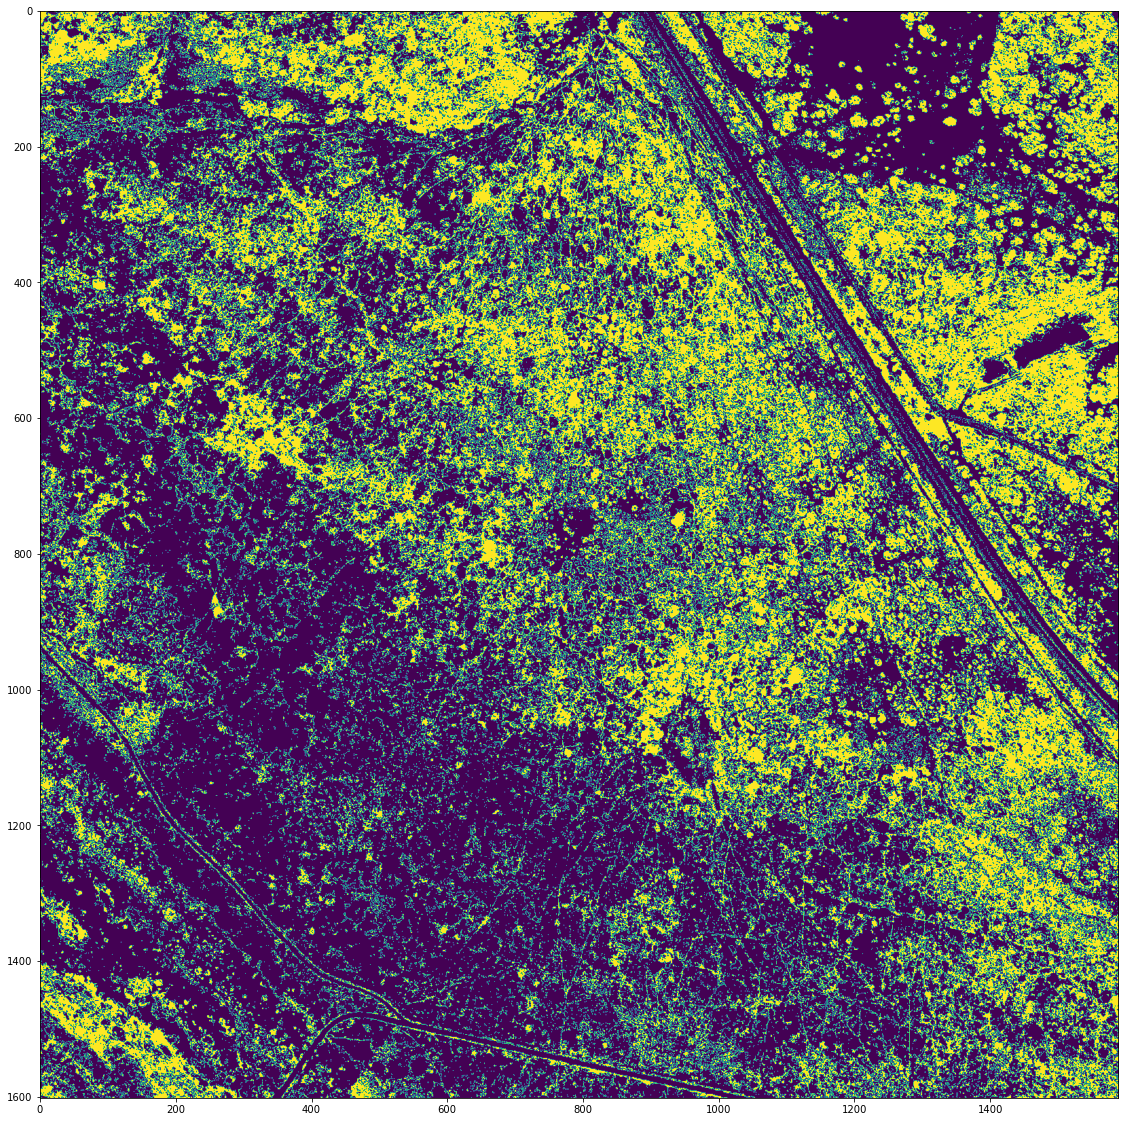

In [68]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(dangermond_iceplant2)
plt.show()

In [ ]:
# Visualization of RGB bands to double check this is our AOI
#plt.imshow(np.moveaxis(rasterio.open(href).read([1,2,3], window=win),0,-1))

URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

# ********* HERE I KNOW WHICH IMAGE TEHSE POINTS ARE IN ******
itemid = itemid,
search = catalog.search(collections=["naip"], ids = itemid)
item = list(search.get_items())[0]
# sign and open item
href = pc.sign(item.assets["image"].href)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(np.moveaxis(rasterio.open(href).read([1,2,3], window=win),0,-1))
plt.show()